<a href="https://colab.research.google.com/github/Marccrampe/ComputerVisionForCableAnalysis/blob/main/Inframent_cable_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction :**

Welcome to this Google Colab notebook! In this project, we aim to automate the identification and counting of cables in images using machine learning techniques. The goal is to preprocess images to isolate specific features—such as bright cyan blue colors representing cables—classify the type of cables using a pre-trained model, and estimate the number of cables present.

**Workflow Overview:**

- ***Preprocessing:*** We'll begin by preparing the images, filtering out everything except the bright cyan blue colors that likely represent the cables.

- ***Categorization:*** Next, using a pre-trained machine learning model, we'll classify the type of cables detected in the images into categories like 'F-Duct', 'Dac', or 'Other'.

- ***Counting Cables:*** Finally, we'll slice the preprocessed images into sections, apply image processing techniques to detect and count the number of cables present.

By following these steps, we aim to provide an automated solution for cable identification and counting, which can be applied to various scenarios in infrastructure management and inspection tasks.


Let's dive into the implementation and explore how these techniques can be applied in practice!

We check gather the data and do a preprocessing to extract only the cable/wire:



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


This one , you have to do it only once it will preproccess the images, with removing the background and keeping the cable only !
All the images will go to a new file called "*images_preprocessed*"

In [18]:
import os
import cv2
import numpy as np

# Path to the folder containing the images
images_dir = '/content/drive/MyDrive/Inframent/Images/' #Replace with your folder path

# Output path for the preprocessed images
output_dir = '/content/drive/MyDrive/Inframent/images_preprocessed/'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to preprocess an image by filtering out bright cyan blue
def preprocess_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert from BGR to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply a filter to keep only bright cyan blue colors
    lower_blue = np.array([80, 150, 150])  # Adjust according to your needs
    upper_blue = np.array([120, 255, 255])  # Adjust according to your needs
    mask = cv2.inRange(image_hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Save the preprocessed image
    cv2.imwrite(output_path, result)
    print(f"Processed image saved at: {output_path}")

# Preprocess all images in the source folder
for filename in os.listdir(images_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(images_dir, filename)
        output_path = os.path.join(output_dir, filename)  # Output path for the preprocessed image
        preprocess_image(image_path, output_path)


Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_080959.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_084939.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_102852.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_103612.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_104017.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_104240.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_104321.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_133756.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/IMG_20230413_141326.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preproc

Explanation of Paths for New Users

- **images_dir**: This is the path to the directory where your original images are stored. In this example, it is set to /content/drive/MyDrive/Inframent/images/. If your images are in a different folder, update this path accordingly.

- **output_dir**: This is the path to the directory where you want to save the preprocessed images. In this example, it is set to /content/drive/MyDrive/Inframent/images_preprocessed/.
You can change this path to any directory where you have write permissions.


- **File** **Extensions**: The code processes images with .jpg, .jpeg, and .png extensions. If you have images in other formats, you can add the corresponding extensions to the condition if filename.endswith(('.jpg', '.jpeg', '.png')).

We slice the image to count on all the slices to be more accurate of the number of wire !!

In [6]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Function to slice the image into vertical or horizontal slices and estimate the number of wires
def slice_and_count_wires(image, num_slices=8, orientation='vertical'):
    # Get image dimensions
    height, width, _ = image.shape

    # Determine slice dimensions based on orientation
    if orientation == 'vertical':
        slice_size = width // num_slices
    elif orientation == 'horizontal':
        slice_size = height // num_slices
    else:
        print("Error: Orientation must be either 'vertical' or 'horizontal'.")
        return

    # List to store the number of wires in each slice
    wires_counts = []

    for i in range(num_slices):
        if orientation == 'vertical':
            slice_start = i * slice_size
            slice_end = (i + 1) * slice_size if i < num_slices - 1 else width
            slice_image = image[:, slice_start:slice_end]
        else:  # horizontal
            slice_start = i * slice_size
            slice_end = (i + 1) * slice_size if i < num_slices - 1 else height
            slice_image = image[slice_start:slice_end, :]

        # Convert the image to grayscale
        gray = cv2.cvtColor(slice_image, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding to binarize the image
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

        # Apply dilation to connect neighboring cable areas
        kernel = np.ones((10, 10), np.uint8)
        dilated = cv2.dilate(thresh, kernel, iterations=1)

        # Find contours in the dilated image
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Add the number of detected wires in the slice to the list
        wires_counts.append(len(contours))

        # Draw the contours on the original image (optional)
        cv2.drawContours(slice_image, contours, -1, (0, 255, 0), 2)

        # Display the image with contours (optional)
        cv2_imshow(cv2.cvtColor(slice_image, cv2.COLOR_BGR2RGB))
        print(f"Number of wires in slice #{i+1} : {len(contours)}")

    # Calculate the average number of detected wires in the slices
    average_wires = np.mean(wires_counts)
    print(f"Average number of wires per slice : {average_wires}")
    return int(average_wires)

# Path to the image to be loaded (modify as needed)
image_path = '/content/drive/MyDrive/Inframent/Train/IMG_20230413_123844.jpg'

# Check if the file exists
if not os.path.exists(image_path):
    print(f"Error: The image {image_path} does not exist.")
else:
    try:
        # Load the image
        image = cv2.imread(image_path)

        # Check if the image is loaded correctly
        if image is None:
            print(f"Error: Unable to load the image {image_path}. Ensure the path is correct.")
        else:
            # Call the function to slice the image and estimate the number of wires
            slice_and_count_wires(image, num_slices=8, orientation='vertical')  # Modify num_slices and orientation as desired

    except Exception as e:
        print(f"Error processing the image: {str(e)}")


Average number of wires per slice : 19.375


# **Explanation for New Users**

- Orientation of Wires: For better accuracy, the cables in the images should be oriented either vertically or horizontally. This ensures that the slicing correctly intersects the cables for proper detection.


**Choosing Slicing Orientation:**

- orientation='vertical': This will slice the image into vertical sections.

- orientation='horizontal': This will slice the image into horizontal sections.

- image_path: This is the path to the image file you want to process. In this example, it is set to /content/drive/MyDrive/Inframent/Train/IMG_20230413_075440.jpg. If your image is located in a different directory, update this path accordingly.

Slicing and Counting Wires: The function slice_and_count_wires is called to slice the image and estimate the number of wires. The parameters num_slices and orientation can be modified to suit your needs. num_slices determines the number of slices, and orientation can be either 'vertical' or 'horizontal'.



Creating a Labeled Dataset for Wire Type Prediction
Now that we have preprocessed our images, the next step is to label the data to build a clean dataset. This labeled dataset will be used to train a predictive model, such as a Convolutional Neural Network (CNN). However, before diving into the complexity of CNNs, we will start with a simpler model, like a Multi-Layer Perceptron (MLP), to get an initial understanding of the data and its predictive capabilities.

Preprocessing and Labeling Images for Wire Type Prediction
The following code preprocesses images by filtering bright cyan blue colors and organizes them into labeled categories. This will help in creating a clean dataset for training a machine learning model to predict the type of wire. The labeled images are then saved in a structured output directory.

In [19]:
import os
import cv2
import numpy as np
from google.colab import drive


# Path to the directories containing the labeled images
base_dir = '/content/drive/MyDrive/Inframent/Images/'
categories = ['F-Duct', 'DAC', 'Other']

# Output path for the preprocessed images
output_dir = '/content/drive/MyDrive/Inframent/images_preprocessed/'
os.makedirs(output_dir, exist_ok=True)

# Preprocess all images in the original directories
for category in categories:
    category_dir = os.path.join(base_dir, category)
    output_category_dir = os.path.join(output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    for filename in os.listdir(category_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(category_dir, filename)
            output_path = os.path.join(output_category_dir, filename)
            preprocess_image(image_path, output_path)


Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_091311.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_091803.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_091806.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_103045.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_103315.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_103329.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_103342.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_103945.jpg
Processed image saved at: /content/drive/MyDrive/Inframent/images_preprocessed/F-Duct/IMG_20230413_124553.jpg
Processed 

**Path to Labeled Images:**

- ***base_dir*** is the path to the directory containing subdirectories of labeled images. Each subdirectory should be named according to the category (e.g., 'F-Duct', 'DAC', 'Other').


- ***output_dir*** is the path where the preprocessed images will be saved. The directory is created if it doesn't already exist using os.makedirs(output_dir, exist_ok=True).


The script iterates over all the images in each category directory, preprocesses them, and saves them to the corresponding output directory.

In [ ]:
#We do split the dataset into, train and test

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

# Assuming 'categories' is defined earlier in your code
# Create a list of image paths and their labels
data = []
labels = []

for category in categories:
    category_dir = os.path.join(output_dir, category)
    label = categories.index(category)
    for filename in os.listdir(category_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(category_dir, filename)
            data.append(image_path)
            labels.append(label)

# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and labels into numpy arrays
X_train = np.array([load_and_preprocess_image(path) for path in train_data])
y_train = np.array(train_labels)
X_test = np.array([load_and_preprocess_image(path) for path in test_data])
y_test = np.array(test_labels)


**Creating Data and Labels Lists:**

The data list stores paths to image files (image_path) and the labels list stores corresponding numeric labels (label) for each category in categories.
Splitting Data:

***train_test_split*** function from scikit-learn is used to split data and labels into training (train_data, train_labels) and test (test_data, test_labels) sets. test_size=0.2 specifies that 20% of the data will be used for testing.
Loading and Preprocessing Images:

***load_and_preprocess_image*** function loads an image from image_path, resizes it to target_size (default is (128, 128)), converts it from BGR to RGB (since OpenCV loads images as BGR by default), and normalizes pixel values to the range [0, 1] by dividing by 255.0.
Converting to Numpy Arrays:

List comprehensions are used to apply load_and_preprocess_image to each path in train_data and test_data, converting them into numpy arrays X_train and X_test, respectively.
y_train and y_test are also converted to numpy arrays from train_labels and test_labels.

**Notes:**

Make sure categories, output_dir, and other variables are defined appropriately before running this code.
This code assumes that images are stored in subdirectories inside output_dir with each subdirectory representing a different category.
Adjust target_size in load_and_preprocess_image as needed based on your model's input size requirements.


CNN model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

# Create the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Convolutional layer with 32 filters
    MaxPooling2D((2, 2)),  # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters
    MaxPooling2D((2, 2)),  # Max pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with 128 filters
    MaxPooling2D((2, 2)),  # Max pooling layer
    Flatten(),  # Flatten the 3D output to 1D
    Dense(128, activation='relu'),  # Fully connected layer with 128 units
    Dropout(0.5),  # Dropout layer with 50% rate to prevent overfitting
    Dense(len(categories), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Path to save the model
model_save_path = '/content/drive/MyDrive/Inframent/model_cable_classification.h5'

# Save the entire model
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Epoch 1/10
2/2 [==============================] - 2s 466ms/step - loss: 1.1350 - accuracy: 0.3077 - val_loss: 0.3979 - val_accuracy: 0.9000
Epoch 2/10
2/2 [==============================] - 1s 375ms/step - loss: 0.5892 - accuracy: 0.7179 - val_loss: 0.4063 - val_accuracy: 0.9000
Epoch 3/10
2/2 [==============================] - 1s 357ms/step - loss: 0.5556 - accuracy: 0.7179 - val_loss: 0.3732 - val_accuracy: 0.9000
Epoch 4/10
2/2 [==============================] - 1s 283ms/step - loss: 0.4531 - accuracy: 0.7436 - val_loss: 0.3839 - val_accuracy: 0.9000
Epoch 5/10
2/2 [==============================] - 1s 282ms/step - loss: 0.3976 - accuracy: 0.7949 - val_loss: 0.4492 - val_accuracy: 0.7000
Epoch 6/10
2/2 [==============================] - 1s 413ms/step - loss: 0.2969 - accuracy: 0.9231 - val_loss: 0.5176 - val_accuracy: 0.7000
Epoch 7/10
2/2 [==============================] - 2s 442ms/step - loss: 0.2670 - accuracy: 0.8718 - val_loss: 0.5639 - val_accuracy: 0.7000
Epoch 8/10
2/2 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

1/1 - 0s - loss: 0.9226 - accuracy: 0.7000 - 95ms/epoch - 95ms/step

Test accuracy: 0.699999988079071


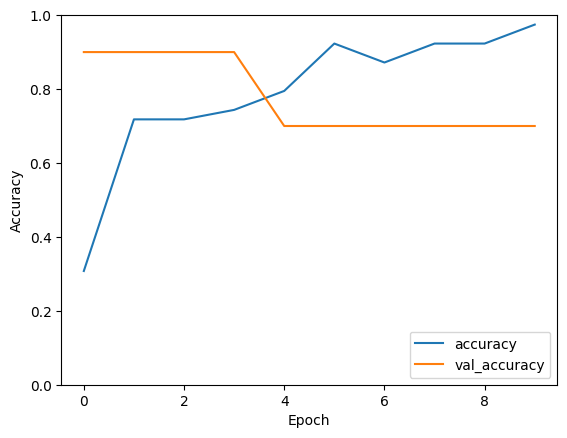

In [25]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Now we have :
- segmentation of the image to isolate the wire
- count the numbe of wire in the image
- a trained CNN that identify the category of wire

So we can now identify for every new pics

1/1 [==============================] - 0s 148ms/step
Cable Type: Dac
Number of cables: 10


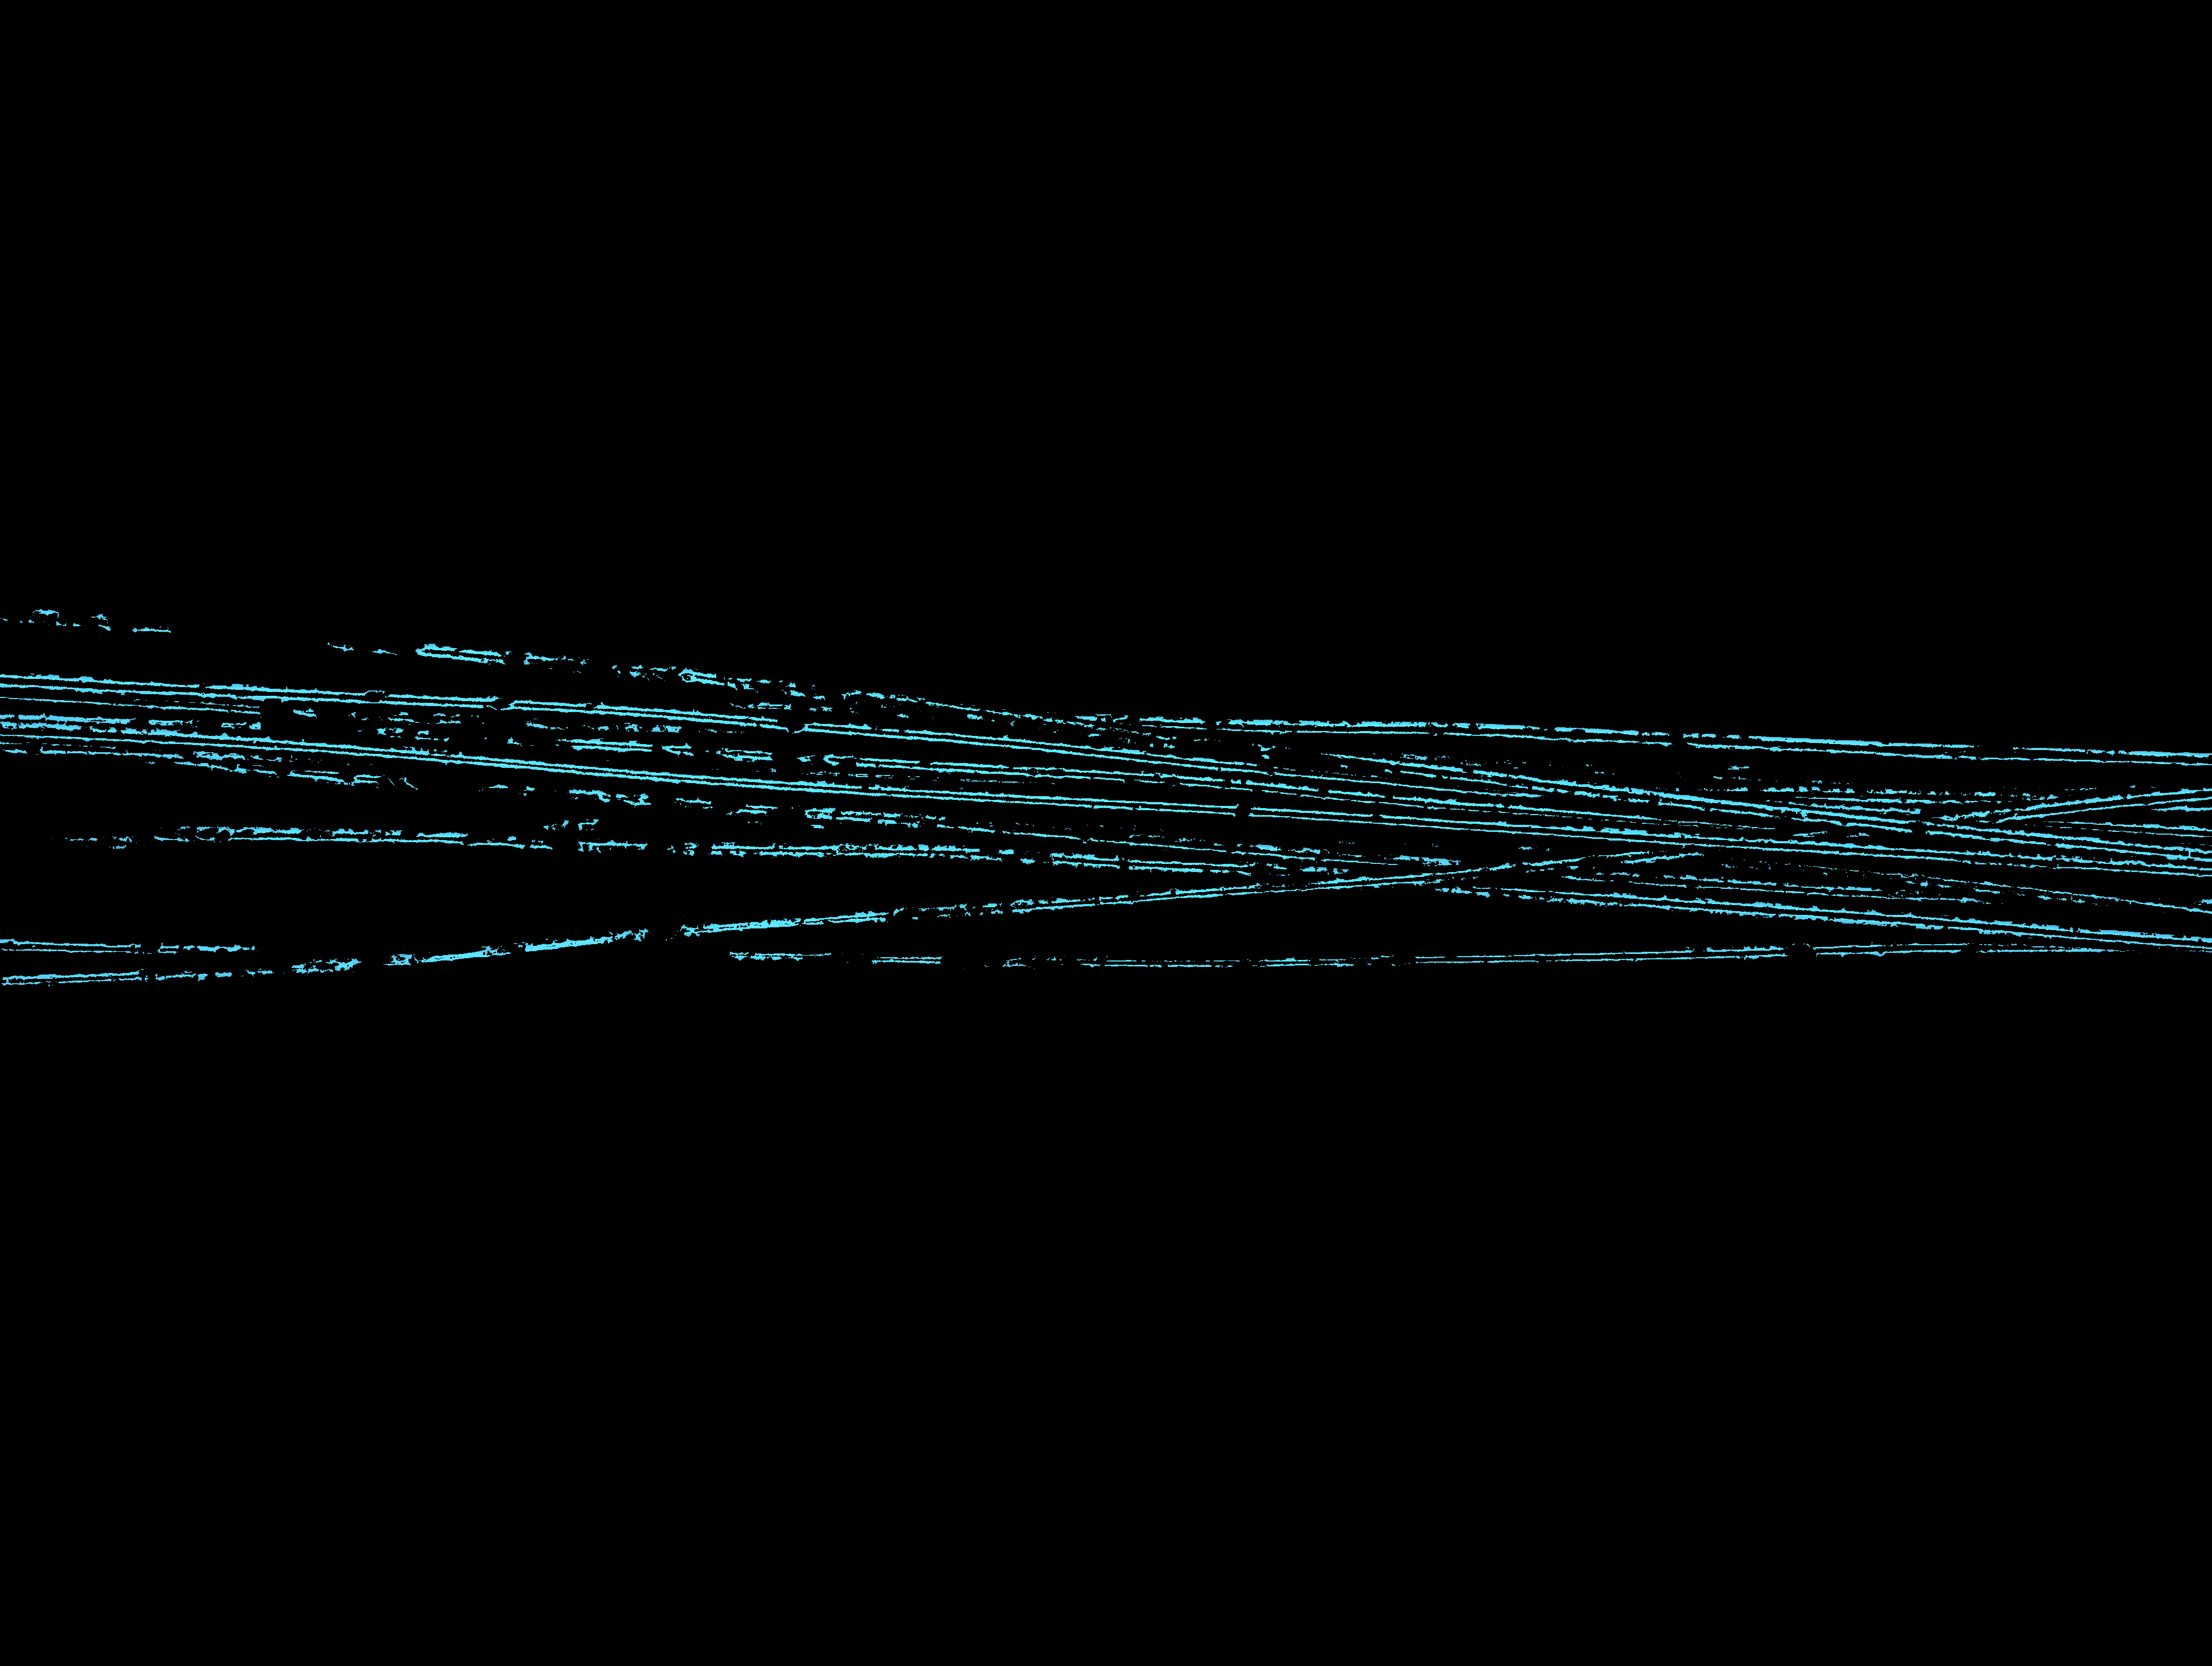

In [14]:
import os
import cv2
import numpy as np
from google.colab import drive
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

# Load the pre-trained model
model_path = '/content/drive/MyDrive/Inframent/model_cable_classification.h5'
model = load_model(model_path)

# Cable categories
categories = ['F-Duct', 'Dac', 'Other']

# Function to preprocess an image by filtering bright cyan blue
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert from BGR to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply a filter to keep only bright cyan blue colors
    lower_blue = np.array([80, 150, 150])
    upper_blue = np.array([120, 255, 255])
    mask = cv2.inRange(image_hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(image, image, mask=mask)

    return result

# Function to identify the type of cable
def identify_cable_type(image):
    image_resized = cv2.resize(image, (128, 128))
    image_array = np.expand_dims(image_resized / 255.0, axis=0)  # Normalize and expand dimensions
    prediction = model.predict(image_array)
    cable_type_index = np.argmax(prediction)
    cable_type = categories[cable_type_index]
    return cable_type

# Function to count the number of cables
def slice_and_count_wires(image, num_slices=64, direction='vertical'):
    height, width, _ = image.shape
    if direction == 'vertical':
        slice_width = width // num_slices
        slices = [image[:, i * slice_width:(i + 1) * slice_width] for i in range(num_slices)]
    else:
        slice_height = height // num_slices
        slices = [image[i * slice_height:(i + 1) * slice_height, :] for i in range(num_slices)]

    wires_counts = []

    for slice_image in slices:
        gray = cv2.cvtColor(slice_image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
        kernel = np.ones((10, 10), np.uint8)
        dilated = cv2.dilate(thresh, kernel, iterations=1)
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        wires_counts.append(len(contours))

    average_wires = np.mean(wires_counts)
    return int(average_wires)

# Main function to process and identify an image
def process_and_identify(image_path):
    if not os.path.exists(image_path):
        print(f"Error: The image {image_path} does not exist.")
        return

    try:
        # Preprocess the image
        preprocessed_image = preprocess_image(image_path)

        # Identify the type of cable
        cable_type = identify_cable_type(preprocessed_image)

        # Count the number of cables
        number_of_wires = slice_and_count_wires(preprocessed_image, num_slices=64)

        # Display the results
        print(f"Cable Type: {cable_type}")
        print(f"Number of cables: {number_of_wires}")
        cv2_imshow(preprocessed_image)

    except Exception as e:
        print(f"Error processing the image: {str(e)}")

# Example usage
image_path = '/content/drive/MyDrive/Inframent/Train/IMG_20230413_080918.jpg'
process_and_identify(image_path)


**Summary of the Workflow**

- ***Preprocessing***: Load the image, convert it to a suitable color format, and filter out everything except bright cyan blue, isolating the cables.

- ***Categorization***: Resize and normalize the preprocessed image, then use a pre-trained machine learning model to predict the type of cable, such as 'F-Duct', 'Dac', or 'Other'.

- ***Counting Cables***: Slice the preprocessed image into sections, convert each section to grayscale, apply a binary filter to highlight the cables, and count the number of detected cable-like shapes.

- ***Main Function***: Combine these steps to preprocess the image, identify the cable type, count the cables, and display the results.

## ***Credits***

This project was developed by [Marc Crampe](https://www.linkedin.com/in/marc-crampe-bb80b1258/) as part of the Inframent initiative.
